In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
torch.manual_seed(42)
import matplotlib.pyplot as plt
from PIL import Image
import skimage
np.random.seed(42)
torch.manual_seed(42)

In [2]:
class relu_mlp(nn.Module):
  def __init__(self, neurons, h_layers):
    super(relu_mlp, self).__init__()
    self.neurons = neurons
    self.h_layers = h_layers

    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(2,neurons))
    for i in range (h_layers-1):
      self.layers.append(nn.Linear(neurons,neurons))
    self.layers.append(nn.Linear(neurons, 3))
  
  def forward (self,x):
    for layer in self.layers[:-1]:
      x = F.relu(layer(x))
    x = self.layers[-1](x)
    return x

In [3]:
class siren_mlp(nn.Module):
  def __init__(self, neurons, h_layers, omega):
    super(siren_mlp, self).__init__()
    self.neurons = neurons
    self.h_layers = h_layers
    self.omega = omega

    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(2, neurons))
    for i in range(h_layers-1):
      self.layers.append(nn.Linear(neurons, neurons))
    self.layers.append(nn.Linear(neurons,3))

    nn.init.uniform_(self.layers[0].weight,-1/2,1/2)
    for layer in self.layers[1:]:
      nn.init.uniform_(layer.weight,-np.sqrt(6/neurons)/omega, np.sqrt(6/neurons)/omega)
  
  def forward (self, x):
    for layer in self.layers[:-1]:
      x = torch.sin(layer(x))
    x = self.layers[-1](x)
    return x

In [4]:
def coordinates (n):
  # Create an empty list to store the tuples
  tuples = []

  # Iterate over all x and y values from 0 to 512
  for x in range(n):
      for y in range(n):
          # Append the current tuple to the list
          tuples.append([x, y])

  # Convert the list to a NumPy array if desired
  tuples_array = np.array(tuples)
  return tuples_array

In [8]:
%cd --

/root


In [17]:
import os
os.chdir("/content/drive/MyDrive")

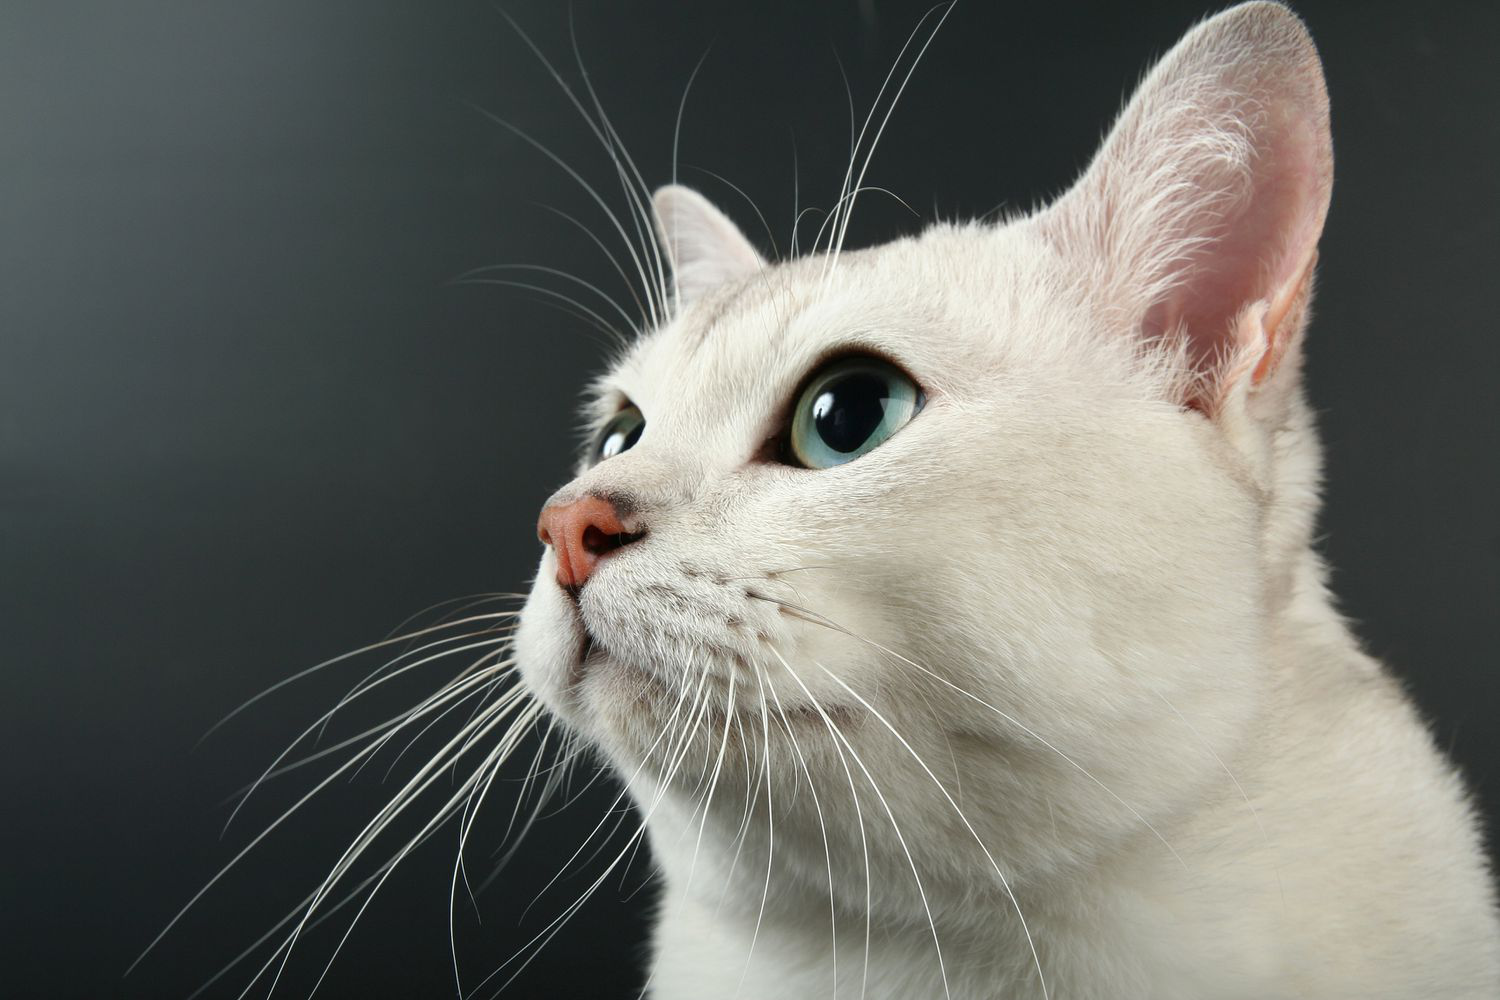

In [20]:
from PIL import Image

img = Image.open('cat.jpeg')
img.show()

In [21]:
img.size

(1500, 1000)

In [24]:
img = img.resize((256,256))

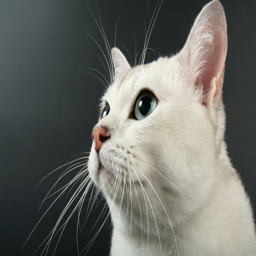

In [25]:
img

In [26]:
image_array = np.array(img)

In [27]:
image_array

array([[[ 89, 101, 101],
        [ 88, 100, 100],
        [ 88, 100, 100],
        ...,
        [ 40,  46,  44],
        [ 40,  46,  44],
        [ 41,  47,  45]],

       [[ 88, 100, 100],
        [ 88, 100, 100],
        [ 88, 100, 100],
        ...,
        [ 40,  46,  44],
        [ 40,  46,  44],
        [ 41,  47,  45]],

       [[ 89, 101, 101],
        [ 89, 101, 101],
        [ 88, 100, 100],
        ...,
        [ 42,  48,  46],
        [ 41,  47,  45],
        [ 41,  47,  45]],

       ...,

       [[ 21,  27,  27],
        [ 20,  26,  26],
        [ 21,  27,  27],
        ...,
        [170, 170, 158],
        [171, 171, 162],
        [166, 167, 156]],

       [[ 19,  27,  26],
        [ 20,  25,  26],
        [ 21,  24,  25],
        ...,
        [173, 173, 161],
        [169, 169, 159],
        [162, 164, 153]],

       [[ 18,  26,  25],
        [ 19,  24,  25],
        [ 20,  23,  25],
        ...,
        [175, 175, 163],
        [172, 172, 162],
        [167, 169, 158]]

In [28]:
image_array.shape

(256, 256, 3)

In [33]:
X = coordinates(256)
X

array([[  0,   0],
       [  0,   1],
       [  0,   2],
       ...,
       [255, 253],
       [255, 254],
       [255, 255]])

In [41]:
len(X)

65536

In [34]:
y = []
for x in X:
  vectors = [image_array[x[0]][x[1]][i] for i in range(3)]
  y.append(vectors)

In [57]:
len(y)

65536

In [55]:
y = np.array(y)

In [42]:
from tqdm import tqdm

In [43]:
device = 'cuda'

In [44]:
relu_model = relu_mlp(256,4).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(relu_model.parameters(), lr=0.0001)

In [53]:
a = torch.tensor([[1,1], [0,0]], dtype=torch.float32)
b = torch.tensor([[3,4], [1,1]], dtype=torch.float32)
criterion(a,b)

tensor(3.7500)

In [56]:
relu_psnr = []

In [77]:
num_epochs = 1000
for e in tqdm(range(num_epochs)):
  y_pred_train = relu_model(torch.from_numpy(X.astype('float32')).to(device)).squeeze()
  loss = criterion(y_pred_train, torch.from_numpy(y.astype('float32')).to(device)) # loss is a tensor which stores the current value of train loss
  relu_psnr.append(20 * np.log10(1.0 / np.sqrt(loss.item())))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 100 == 0:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss
  if e == num_epochs-1:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss

  0%|          | 4/1000 [00:00<00:34, 29.09it/s]

Epoch [0/1000], Loss: 683.7406


 11%|█         | 107/1000 [00:03<00:24, 36.08it/s]

Epoch [100/1000], Loss: 680.4171


 21%|██        | 207/1000 [00:05<00:22, 35.80it/s]

Epoch [200/1000], Loss: 665.8541


 31%|███       | 307/1000 [00:08<00:19, 35.52it/s]

Epoch [300/1000], Loss: 726.1296


 41%|████      | 407/1000 [00:11<00:16, 35.23it/s]

Epoch [400/1000], Loss: 714.4355


 51%|█████     | 507/1000 [00:14<00:13, 35.29it/s]

Epoch [500/1000], Loss: 680.7737


 61%|██████    | 607/1000 [00:17<00:11, 35.07it/s]

Epoch [600/1000], Loss: 659.3785


 71%|███████   | 707/1000 [00:20<00:08, 34.85it/s]

Epoch [700/1000], Loss: 678.1626


 81%|████████  | 807/1000 [00:22<00:05, 34.60it/s]

Epoch [800/1000], Loss: 697.3358


 91%|█████████ | 907/1000 [00:25<00:02, 34.59it/s]

Epoch [900/1000], Loss: 656.4387


100%|██████████| 1000/1000 [00:28<00:00, 35.09it/s]

Epoch [999/1000], Loss: 709.0409


In [130]:
len(relu_psnr)

15000

In [79]:
y_preds = relu_model(torch.from_numpy(X.astype('float32')).to(device))

In [82]:
y_preds.shape

torch.Size([65536, 3])

In [84]:
X

array([[  0,   0],
       [  0,   1],
       [  0,   2],
       ...,
       [255, 253],
       [255, 254],
       [255, 255]])

In [85]:
X.shape

(65536, 2)

In [86]:
image_array

array([[[ 89, 101, 101],
        [ 88, 100, 100],
        [ 88, 100, 100],
        ...,
        [ 40,  46,  44],
        [ 40,  46,  44],
        [ 41,  47,  45]],

       [[ 88, 100, 100],
        [ 88, 100, 100],
        [ 88, 100, 100],
        ...,
        [ 40,  46,  44],
        [ 40,  46,  44],
        [ 41,  47,  45]],

       [[ 89, 101, 101],
        [ 89, 101, 101],
        [ 88, 100, 100],
        ...,
        [ 42,  48,  46],
        [ 41,  47,  45],
        [ 41,  47,  45]],

       ...,

       [[ 21,  27,  27],
        [ 20,  26,  26],
        [ 21,  27,  27],
        ...,
        [170, 170, 158],
        [171, 171, 162],
        [166, 167, 156]],

       [[ 19,  27,  26],
        [ 20,  25,  26],
        [ 21,  24,  25],
        ...,
        [173, 173, 161],
        [169, 169, 159],
        [162, 164, 153]],

       [[ 18,  26,  25],
        [ 19,  24,  25],
        [ 20,  23,  25],
        ...,
        [175, 175, 163],
        [172, 172, 162],
        [167, 169, 158]]

In [87]:
image_array.shape

(256, 256, 3)

In [94]:
vals  = y_preds.cpu().detach().numpy().reshape(256,256,3).astype('uint8')

In [95]:
vals

array([[[ 89, 101, 101],
        [ 88, 100, 100],
        [ 88, 100, 100],
        ...,
        [ 26,  33,  31],
        [ 25,  32,  30],
        [ 24,  31,  30]],

       [[ 88, 100, 100],
        [ 88, 100, 100],
        [ 88, 100, 100],
        ...,
        [ 26,  33,  32],
        [ 25,  33,  31],
        [ 24,  32,  30]],

       [[ 89, 101, 101],
        [ 89, 100, 101],
        [ 89, 100, 101],
        ...,
        [ 27,  34,  33],
        [ 26,  33,  32],
        [ 25,  33,  31]],

       ...,

       [[ 23,  30,  32],
        [ 23,  30,  32],
        [ 23,  29,  31],
        ...,
        [196, 194, 177],
        [197, 195, 177],
        [197, 195, 178]],

       [[ 23,  30,  32],
        [ 23,  29,  32],
        [ 23,  29,  31],
        ...,
        [196, 194, 177],
        [196, 194, 177],
        [197, 195, 177]],

       [[ 23,  29,  32],
        [ 23,  29,  31],
        [ 23,  29,  31],
        ...,
        [195, 193, 176],
        [196, 194, 177],
        [196, 194, 177]]

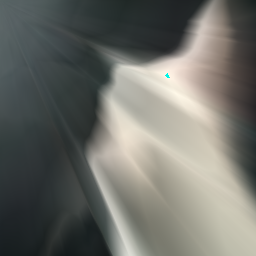

In [96]:
relu_image = Image.fromarray(vals)
relu_image.show()

In [97]:
siren_model = siren_mlp(256,4,30).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(siren_model.parameters(), lr=0.0001)

In [98]:
siren_psnr = []

In [121]:
num_epochs = 1000
for e in tqdm(range(num_epochs)):
  y_pred_train = siren_model(torch.from_numpy(X.astype('float32')).to(device)).squeeze()
  loss = criterion(y_pred_train, torch.from_numpy(y.astype('float32')).to(device)) # loss is a tensor which stores the current value of train loss
  siren_psnr.append(20 * np.log10(1.0 / np.sqrt(loss.item())))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 100 == 0:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss
  if e == num_epochs-1:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss

  1%|          | 6/1000 [00:00<00:38, 25.55it/s]

Epoch [0/1000], Loss: 30.5569


 11%|█         | 106/1000 [00:03<00:27, 32.17it/s]

Epoch [100/1000], Loss: 30.0351


 21%|██        | 206/1000 [00:06<00:24, 32.21it/s]

Epoch [200/1000], Loss: 29.5694


 31%|███       | 306/1000 [00:09<00:21, 31.87it/s]

Epoch [300/1000], Loss: 29.4631


 41%|████      | 406/1000 [00:12<00:18, 31.91it/s]

Epoch [400/1000], Loss: 28.4680


 51%|█████     | 506/1000 [00:15<00:15, 31.49it/s]

Epoch [500/1000], Loss: 27.8031


 61%|██████    | 606/1000 [00:19<00:12, 31.38it/s]

Epoch [600/1000], Loss: 27.7326


 71%|███████   | 706/1000 [00:22<00:09, 31.00it/s]

Epoch [700/1000], Loss: 27.2930


 81%|████████  | 806/1000 [00:25<00:06, 30.71it/s]

Epoch [800/1000], Loss: 26.5584


 91%|█████████ | 906/1000 [00:28<00:03, 30.54it/s]

Epoch [900/1000], Loss: 25.8619


100%|██████████| 1000/1000 [00:31<00:00, 31.40it/s]

Epoch [999/1000], Loss: 25.5260


In [122]:
len(siren_psnr)

15000

In [124]:
y_preds = siren_model(torch.from_numpy(X.astype('float32')).to(device))

In [125]:
vals  = y_preds.cpu().detach().numpy().reshape(256,256,3).astype('uint8')

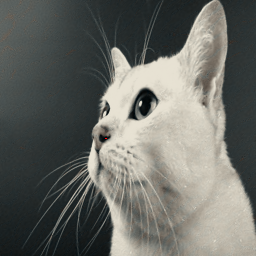

In [126]:
siren_image = Image.fromarray(vals)
siren_image.show()

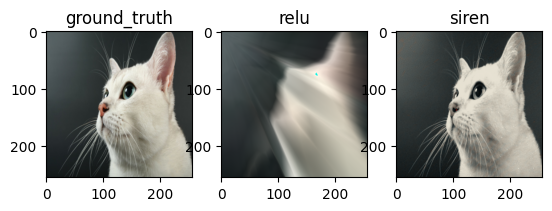

In [129]:
fix, ax = plt.subplots(1,3)
ax[0].imshow(img)
ax[0].set(title = 'ground_truth')
ax[1].imshow(relu_image)
ax[1].set(title = 'relu')
ax[2].imshow(siren_image)
ax[2].set(title = 'siren')
plt.show()